In [1]:
import os
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import classification_report, confusion_matrix

In [2]:
DATA_DIR = "C:/Users/Yakina/.cache/kagglehub/datasets/mdwaquarazam/agricultural-crops-image-classification/versions/1/Agricultural-crops"

In [3]:
# Define transformations
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

In [4]:
# Dataset and dataloaders
dataset = datasets.ImageFolder(root=DATA_DIR, transform=transform)

In [5]:
# Train-test split
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

In [6]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [7]:
# Define a simple CNN class
class SimpleCNN(nn.Module):
    def __init__(self, num_classes):
        super(SimpleCNN, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(64, 128, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Flatten(),
            nn.Linear(128 * 16 * 16, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        return self.model(x)

In [8]:
# Initialize model
num_classes = len(dataset.classes)
model = SimpleCNN(num_classes)

In [9]:
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [10]:
# Training loop
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
model.to(device)

SimpleCNN(
  (model): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Flatten(start_dim=1, end_dim=-1)
    (10): Linear(in_features=32768, out_features=256, bias=True)
    (11): ReLU()
    (12): Dropout(p=0.5, inplace=False)
    (13): Linear(in_features=256, out_features=30, bias=True)
  )
)

In [11]:
EPOCHS = 50
train_loss_history = []

for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    acc = correct / total

    avg_loss = running_loss / len(train_loader)
    train_loss_history.append(avg_loss)
    
    print(f"Epoch {epoch+1}/{EPOCHS}, Loss: {running_loss:.4f}, Accuracy: {acc:.4f}")

Epoch 1/50, Loss: 71.7883, Accuracy: 0.0347
Epoch 2/50, Loss: 68.3424, Accuracy: 0.0890
Epoch 3/50, Loss: 64.1614, Accuracy: 0.1252
Epoch 4/50, Loss: 60.3997, Accuracy: 0.1840
Epoch 5/50, Loss: 56.9689, Accuracy: 0.2428
Epoch 6/50, Loss: 54.1136, Accuracy: 0.2549
Epoch 7/50, Loss: 53.0106, Accuracy: 0.2474
Epoch 8/50, Loss: 48.7577, Accuracy: 0.3243
Epoch 9/50, Loss: 46.8195, Accuracy: 0.3454
Epoch 10/50, Loss: 44.5103, Accuracy: 0.3665
Epoch 11/50, Loss: 43.7931, Accuracy: 0.3725
Epoch 12/50, Loss: 40.8553, Accuracy: 0.4057
Epoch 13/50, Loss: 38.6197, Accuracy: 0.4706
Epoch 14/50, Loss: 36.4843, Accuracy: 0.4857
Epoch 15/50, Loss: 34.0530, Accuracy: 0.5309
Epoch 16/50, Loss: 31.8336, Accuracy: 0.5385
Epoch 17/50, Loss: 28.4316, Accuracy: 0.5777
Epoch 18/50, Loss: 28.8531, Accuracy: 0.5671
Epoch 19/50, Loss: 26.8091, Accuracy: 0.6425
Epoch 20/50, Loss: 23.0333, Accuracy: 0.6697
Epoch 21/50, Loss: 23.8044, Accuracy: 0.6440
Epoch 22/50, Loss: 21.1938, Accuracy: 0.7029
Epoch 23/50, Loss: 

In [12]:
# Evaluation
model.eval()
y_true = []
y_pred = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

In [13]:
# Classification report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=dataset.classes))


Classification Report:
                     precision    recall  f1-score   support

             Cherry       0.75      0.43      0.55         7
       Coffee-plant       0.20      0.50      0.29         4
           Cucumber       0.00      0.00      0.00         2
   Fox_nut(Makhana)       0.08      0.50      0.14         2
              Lemon       0.20      0.25      0.22         4
         Olive-tree       0.50      0.40      0.44         5
Pearl_millet(bajra)       0.33      0.56      0.42         9
      Tobacco-plant       0.50      0.17      0.25         6
             almond       0.50      0.20      0.29         5
             banana       0.33      0.29      0.31         7
           cardamom       0.00      0.00      0.00         4
             chilli       0.33      0.17      0.22         6
              clove       0.00      0.00      0.00         7
            coconut       0.33      0.25      0.29         4
             cotton       0.50      0.50      0.50         6

c:\Users\Yakina\anaconda3\envs\traineeship\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Yakina\anaconda3\envs\traineeship\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Yakina\anaconda3\envs\traineeship\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is",

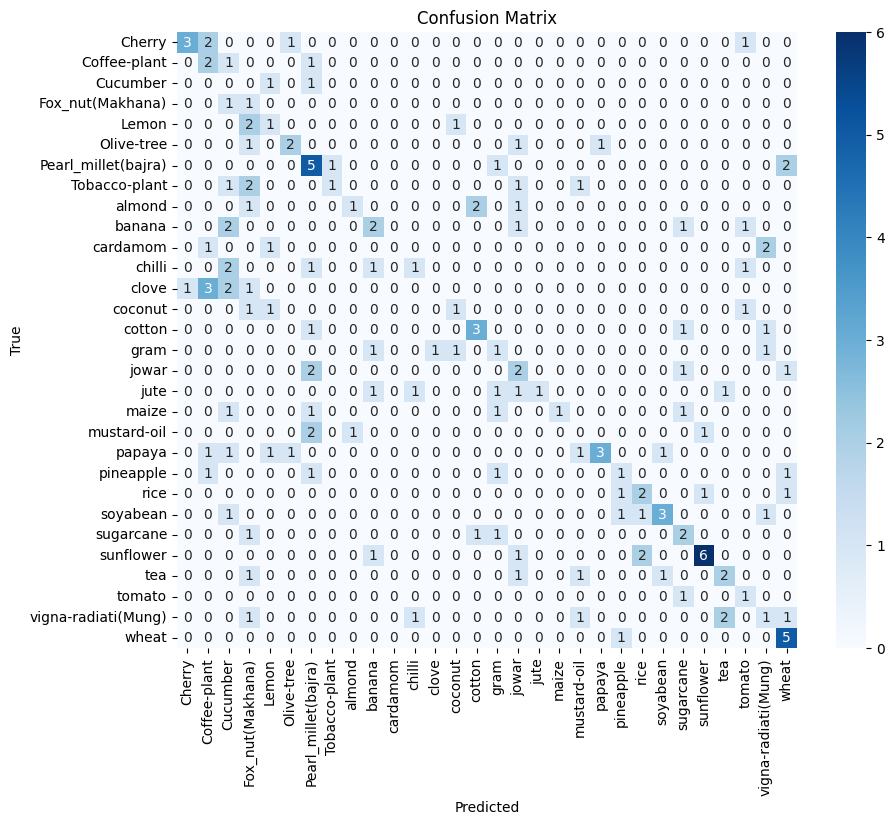

In [14]:
# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=dataset.classes, yticklabels=dataset.classes, cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

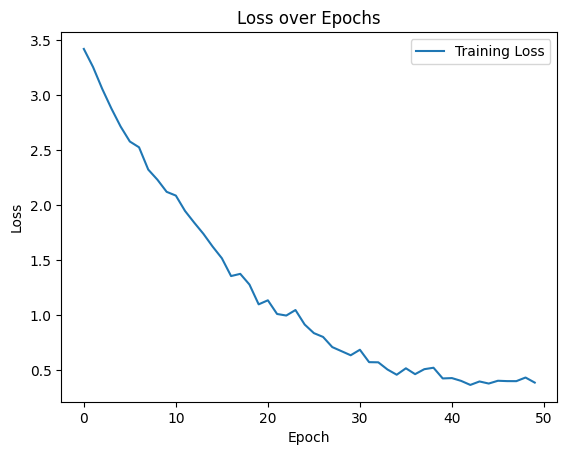

In [15]:
# Loss visualization
plt.plot(train_loss_history, label="Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss over Epochs")
plt.legend()
plt.show()